In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 20
})

In [2]:
n = 200
m = 2
y = np.random.choice([-1,1], n)
X0 = np.random.randn(n, m) - np.array([0.9, 0.9])
X1 = np.random.randn(n, m) - np.array([-0.9, -0.9])
X = X0.copy()
X[y == 1] = X1[y == 1]
y.shape

(200,)

/home/chris/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


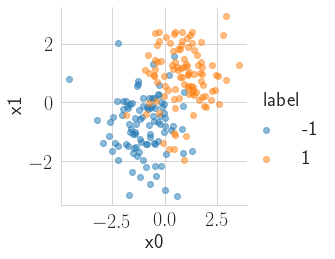

In [3]:
df = pd.DataFrame(X)
df.columns = ['x0', 'x1']
df['label']= y

sns.set_style("whitegrid")
sns.FacetGrid(df, hue="label", size=4) \
   .map(plt.scatter, "x0", "x1", alpha = 0.5) \
   .add_legend()
plt.show()

In [4]:
def calc_p(y):
    if len(y) == 0:
        return 0
    return sum(y == 1)/len(y)

def calc_gini(y):
    p = calc_p(y)
    G = 2*p*(1-p)
    return G
    
def calc_entropy(y):
    p = calc_p(y)
    if p == 0 or p == 1:
        return 0.
    q = 1-p
    entropy = - p*np.log(p) - q*np.log(q)
    return entropy

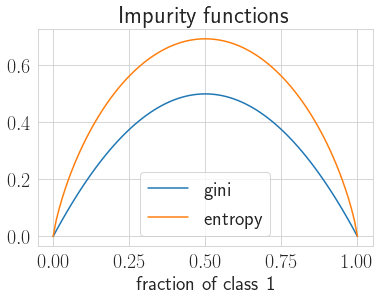

In [5]:
T = 100

G_list = []
E_list = []
p_list = []
for i in range(0, T+1):
    y0 = np.append(np.zeros(i), np.ones(T - i))
    p_list.append(calc_p(y0))
    G_list.append(calc_gini(y0))
    E_list.append(calc_entropy(y0))

plt.plot(p_list, G_list, label = 'gini')
plt.plot(p_list, E_list, label = 'entropy')
plt.xlabel('fraction of class 1')
plt.title('Impurity functions')
plt.legend()

In [6]:
def split_data(feature_idx, threshold, X, y):
    # right for data with feature greater than threshold
    mask_right = X[:, feature_idx] > threshold
    mask_left = np.logical_not(mask_right)
    
    X_left = X[mask_left, :]
    y_left = y[mask_left]
    
    X_right = X[mask_right, :]
    y_right = y[mask_right]
    
    return X_left, y_left, X_right, y_right

def calc_split_entropy(feature_idx, threshold, X, y): 
    
    _, y_left, _, y_right = split_data(feature_idx, threshold, X, y)
    
    H_left = calc_entropy(y_left)
    H_right = calc_entropy(y_right)
    
    p_left = len(y_left)/len(y)
    p_right = len(y_right)/len(y)
    
    H = p_left*H_left + p_right*H_right
    
    return H
    

In [7]:
from collections import namedtuple

Split = namedtuple('Split','feature_idx threshold entropy')

def find_optimal_split(X, y):
    cand_split_list = []
    for feature_idx in range(X.shape[1]):
        x_values = np.sort(X[:, feature_idx])
        # midpoints of all x_values
        threshold_list = (x_values[:-1] + x_values[1:])/2. 
        for threshold in threshold_list:
            entropy = calc_split_entropy(feature_idx, threshold, X, y)
            cand_split = Split(feature_idx = feature_idx, 
                               threshold = threshold, 
                               entropy = entropy)
            cand_split_list.append(cand_split)
    optimal_split = min(cand_split_list, key=lambda split: split.entropy)
    return optimal_split

In [8]:
def numberGenerator():
    number = 0
    while True:
        yield number
        number += 1
id_generator = numberGenerator()

In [9]:
max_depth = 3


def build_tree(X, y, node, level):
    p = calc_p(y)
    level = level + 1
    node['id'] = next(id_generator)
    node['num_samples'] = len(y)
    node['frac_positive'] = p
    if level > max_depth:
        return node
    
    if p == 0 or p == 1:
        return node
    
    split = find_optimal_split(X, y)
    Xl, yl, Xr, yr = split_data(split.feature_idx, split.threshold, X, y)    
    node['split'] = split
    node['left'] = build_tree(Xl, yl, {}, level)
    node['right'] = build_tree(Xr, yr, {}, level)
    
    return node


In [10]:
class DecisionTree:
    def __init__(self, max_depth=5):
        self.root = {}
        self.max_depth = max_depth
        
    def fit(self, X, y):
        level = 0
        node = {}
        self.root = build_tree(X, y, node, level)
    
    def predict(self, X):
        pass

In [11]:
dt = DecisionTree(max_depth=20)
dt.fit(X, y)

In [12]:
dx = 2
visited = set()

def visit(node):
    visited.add(node['id'])
   
    if 'left' in node:
        wll, wlr = visit(node['left'])
        wl = wll + wlr + 0.5*dx
        node['left_dx'] = - 0.5*dx - wlr
    else:
        wl = 0.5*dx
        
    if 'right' in node:
        wrl, wrr = visit(node['right'])
        wr = 0.5*dx + wrl + wrr
        node['right_dx'] = 0.5*dx + wrl
    else:
        wr = 0.5*dx
    
    return wl, wr

visit(dt.root)


(15.0, 11.0)

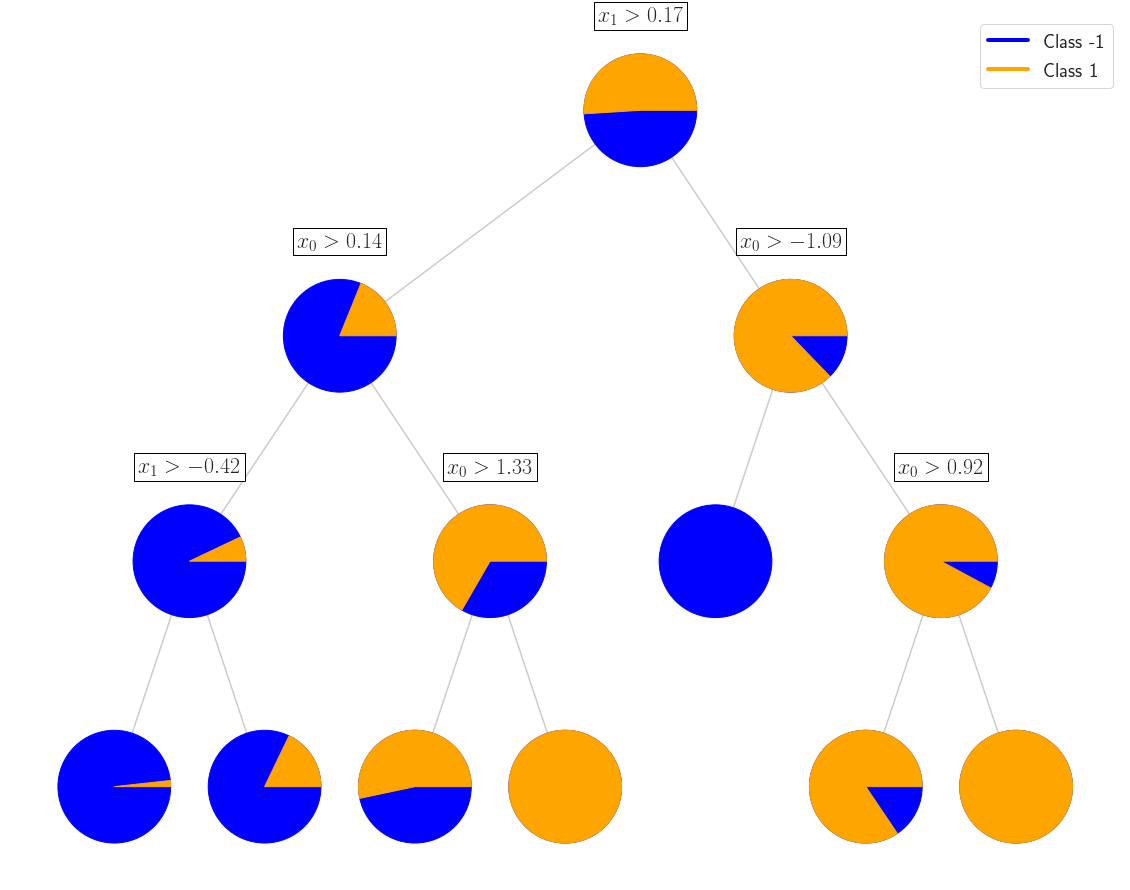

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches
from matplotlib.lines import Line2D

fig = plt.figure(figsize= (20,20))
ax = fig.add_subplot(111)

def visit(node, xp, yp):
    #radius = 2*node['num_samples']/y_len+0.4
    circle = plt.Circle((xp, yp), radius, color='blue', zorder= 1)
    ax.add_patch(circle)
    p = node['frac_positive']
    if p>0:
        theta1 = 0
        theta2 = 360*p
        wedge = patches.Wedge((xp, yp), radius, theta1, theta2, color='orange', zorder= 1, label = 'class 1')
        ax.add_patch(wedge)
    
    if 'split' in node:
        split = node['split']
        ax.text(xp, 
                yp+2.25, 
                rf"$x_{split.feature_idx} > {split.threshold:.2f}$", 
                horizontalalignment='center',
                verticalalignment='bottom',
                size=22,
                bbox=dict(facecolor='white', edgecolor = 'black', alpha=1))
    
    if 'left' in node:
        x = xp + node['left_dx']
        y = yp - dy
        ax.plot([xp, x], [yp, y], color = 'black', zorder= 0, alpha = 0.2)
        visit(node['left'], x, y)
            
    if 'right' in node:
        x = xp + node['right_dx']
        y = yp - dy
        ax.plot([xp, x], [yp, y], color = 'black', zorder= 0, alpha = 0.2)
        visit(node['right'], x, y)
        
        
y_len = len(y)
radius = 1.5
dy=6
visit(dt.root, 0, 0)

cmap = plt.cm.coolwarm
custom_lines = [Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="orange", lw=4)]
ax.legend(custom_lines, ['Class -1', 'Class 1'])

ax.grid(False)
plt.axis('off')
ax.set_aspect('equal')
plt.show()
fig.savefig("../images/decision_tree.svg", format="svg", bbox_inches='tight') 